# Chatbot Description:

This chatbot is a healthcare assistant designed to provide personalized support by:

1. Responding warmly to greetings and assisting with general health questions, appointment bookings, and FAQs.

2. Recommending appropriate doctors based on symptoms using a predefined symptom-to-doctor mapping.

3. Booking appointments with detailed confirmations and directing unresolved queries to hospital staff with clear contact information.


In [1]:
%%capture --no-stderr
%pip install -q -U langgraph langchain_google_genai langchain-community langchain_core dateparser

In [ ]:
import os
from google.colab import userdata

%env GOOGLE_API_KEY = {userdata.get('GEMINI_API_KEY')}
%env LANGCHAIN_API_KEY = {userdata.get('LANGCHAIN_API_KEY')}
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "retailbot-project"

# **Greetings Function:**

1.   Identifies common greetings by comparing the user input to a predefined list (e.g., "hello," "hi," "hey").
2.   Responds warmly and professionally when a greeting is detected.
3.   Introduces the chatbot's capabilities, such as answering health questions, booking appointments, and addressing FAQs.


In [3]:
def greetings(user_input: str) -> str:
    """
    Handles the welcome interaction for the chatbot. Activates only when the user greets.

    Args:
        user_input (str): The text input from the user.

    Returns:
        str: The chatbot's response if the user greets, otherwise a generic help message.
    """
    # Define a list of common greetings
    greetings = ["hello", "hi", "hey", "good morning", "good afternoon", "good evening"]

    # Normalize user input to lowercase for comparison
    normalized_input = user_input.lower().strip()

    # Check if the user input matches any greeting
    if any(greet in normalized_input for greet in greetings):
        return (
            "Welcome! I’m your healthcare assistant. I can help you with general health questions, appointment "
            "bookings, and FAQs about our hospital. How can I assist you today?"
        )

    # If no greeting is detected, return a generic message
    return "Can I help you with anything?"


# **Health Information Function:**

#### 1.   The function uses a predefined dictionary (symptom_to_doctor) that maps common symptoms (e.g., "cough," "fever") to the type of doctor or specialist best suited to handle those symptoms.


#### 2.   It checks the user input for any symptoms listed in the dictionary. If a match is found, it provides a recommendation for the appropriate type of doctor.


#### 3. If no symptom matches are found, it returns a default response requesting more specific details about the user's symptoms to provide better assistance.



In [4]:
def health_information(user_input: str) -> str:
    """
    Handles health-related queries from the user. Provides recommendations
    based on symptoms.
    """
    # Symptom-to-doctor mapping
    symptom_to_doctor = {
        "cough": "general physician",
        "fever": "general physician",
        "cold": "general physician",
        "chest pain": "cardiologist",
        "skin rash": "dermatologist",
        "back pain": "orthopedic specialist",
        "blurred vision": "ophthalmologist",
        "toothache": "dentist",
        "sore throat": "ENT specialist",
        "runny nose": "general physician",
        "headache": "neurologist",
        "joint pain": "rheumatologist",
        "ear pain": "ENT specialist",
        "stomach ache": "gastroenterologist",
        "shortness of breath": "pulmonologist"
    }

    # Normalize user input
    normalized_input = user_input.lower().strip()

    # Match symptoms and return response
    for symptom, doctor in symptom_to_doctor.items():
        if symptom in normalized_input:
            return (
                f"I understand you're experiencing '{symptom}'. I recommend consulting a {doctor}. "
                "If symptoms persist or worsen, please seek immediate medical attention."
            )

    # Default fallback response
    return (
        "I'm sorry, I need more information about your symptoms to help you further. "
        "Could you tell me more details, like if you have a cough, fever, sore throat, or runny nose?"
    )


# **Recommend Doctor and Appointment Booking Function:**


1.   Matches user-provided symptoms with a predefined mapping of symptoms to specific doctors.
2. Recommends an appropriate doctor for the identified symptom or requests additional details if no match is found.
3.   Assists in scheduling, rescheduling, or canceling
     appointments by guiding the user to provide necessary details such as name, preferred date, and time.
4. Extracts user details (name, preferred date/time) and parses symptoms from the input to confirm an appointment.

5. Provides a confirmation message with all appointment details, formatted for clarity.



In [5]:
from datetime import datetime
import dateparser

# Symptom-to-doctor mapping
SYMPTOM_TO_DOCTOR = {
    "cough": "Dr. John Smith (General Physician)",
    "fever": "Dr. John Smith (General Physician)",
    "cold": "Dr. Emily Davis (General Physician)",
    "chest pain": "Dr. Alan Brown (Cardiologist)",
    "skin rash": "Dr. Sarah Wilson (Dermatologist)",
    "back pain": "Dr. Robert Johnson (Orthopedic Specialist)",
    "blurred vision": "Dr. Laura Taylor (Ophthalmologist)",
    "toothache": "Dr. Adam White (Dentist)",
    "sore throat": "Dr. Nancy Green (ENT Specialist)",
    "runny nose": "Dr. Emily Davis (General Physician)",
    "headache": "Dr. Daniel Lee (Neurologist)",
    "joint pain": "Dr. Rachel Adams (Rheumatologist)",
    "ear pain": "Dr. Nancy Green (ENT Specialist)",
    "stomach ache": "Dr. Michael Scott (Gastroenterologist)",
    "shortness of breath": "Dr. Karen Miller (Pulmonologist)"
}

def recommend_doctor(symptoms: str) -> str:
    """
    Recommends a doctor based on symptoms.
    """
    for symptom, doctor in SYMPTOM_TO_DOCTOR.items():
        if symptom in symptoms.lower():
            return f"I recommend you see {doctor} for '{symptom}'."
    return "I'm sorry, I couldn't find a doctor recommendation for your symptoms. Can you provide more details?"

def appointment_booking(user_input: str) -> str:
    """
    Books an appointment based on user's name, preferred date/time, and symptom.
    """
    try:
        # Extract user's name (basic parsing)
        name = user_input.split("My name is ")[1].split(",")[0].strip()

        # Extract the date and time using flexible parsing
        date_time_str = user_input.split(",")[1].strip()  # Assumes the second item is the date and time
        appointment_datetime = dateparser.parse(date_time_str)

        if not appointment_datetime:
            return (
                "I couldn't understand the date and time you provided. "
                "Please include your preferred date and time (e.g., '20 December, 8:00 PM')."
            )

        # Format the parsed date and time
        formatted_date = appointment_datetime.strftime("%d %B")
        formatted_time = appointment_datetime.strftime("%I:%M %p")

        # Match symptoms to a doctor
        for symptom, doctor in SYMPTOM_TO_DOCTOR.items():
            if symptom in user_input.lower():
                return (
                    f"Appointment confirmed!\n"
                    f"Patient Name: {name}\n"
                    f"Date: {formatted_date}\n"
                    f"Time: {formatted_time}\n"
                    f"Doctor: {doctor} (specialist for '{symptom}')\n\n"
                    "If you need to reschedule or cancel, please let me know."
                )

        # If no symptom matches
        return (
            f"Thank you, {name}. Your appointment on {formatted_date} at {formatted_time} is noted.\n"
            "However, I need to know your symptoms to assign the appropriate doctor. Could you provide more details?"
        )

    except Exception as e:
        return (
            f"It seems there was an issue: {str(e)}. "
            "Please include your name, preferred date, time, and any symptoms you have."
        )


# **FAQs Function:**

1.   Matches user queries with predefined FAQ topics, such as hospital services, location, timings, and policies.
2. Responds with accurate and concise answers to common questions.
3. Encourages users to specify their query further if no match is found.


In [6]:
def faqs(user_input: str) -> str:
    """
    Handles frequently asked questions (FAQs) about the hospital. Provides accurate and concise responses
    related to hospital services, locations, timings, and policies. If the user's input does not relate to an FAQ,
    encourages them to specify their query further.

    Args:
        user_input (str): The text input from the user.

    Returns:
        str: The chatbot's response to the FAQ or a prompt encouraging clarification.
    """
    # Predefined FAQs and their answers
    faq_responses = {
        "services": "We offer a variety of services including general medicine, pediatrics, cardiology, and orthopedics.",
        "location": "Our hospital is located at 123 Health Street, Wellness City.",
        "timings": "We are open 24/7 for emergencies. Regular outpatient services are available from 8 AM to 8 PM.",
        "policy": "Patients are required to carry a valid ID for registration. Please adhere to the hospital's mask policy."
    }

    # Normalize user input to lowercase for comparison
    normalized_input = user_input.lower().strip()

    # Check for keywords in the input and respond with the relevant FAQ
    for keyword, response in faq_responses.items():
        if keyword in normalized_input:
            return response

    # If the input does not match any FAQ, provide a general response
    return (
        "I'm here to help with questions about our services, location, timings, or policies. Could you please specify your query?"
    )


# **Staff Query Function:**

1. Detects input that indicates emergencies, complex issues, or requests for staff assistance using predefined keywords.
2. Provides contact information for emergencies or unresolved queries, such as a phone number or email address.
3. Offers a general follow-up response for less urgent cases, inviting further user input.






In [7]:
def staff_query(user_input: str) -> str:
    """
    Handles queries that cannot be resolved by the chatbot and directs users to contact hospital staff for further assistance.
    Provides contact information (phone number or email) for emergencies or complex issues.

    Args:
        user_input (str): The text input from the user.

    Returns:
        str: The chatbot's response, either guiding the user to contact staff or acknowledging their query.
    """
    # Define keywords indicating unresolved queries or emergencies
    unresolved_keywords = ["emergency", "urgent", "complex", "can't help", "staff"]

    # Normalize user input to lowercase for comparison
    normalized_input = user_input.lower().strip()

    # Check if the input contains any unresolved keywords
    if any(keyword in normalized_input for keyword in unresolved_keywords):
        return (
            "I'm sorry that I cannot assist with this directly. For emergencies, please contact our staff immediately at 123-456-7890. "
            "For other complex issues, you can email us at support@hospital.com. Let me know if there’s anything else I can help with."
        )

    # If no unresolved keyword is detected, provide a general response
    return (
        "Let me know how I can assist you further. For urgent matters, please contact our staff directly."
    )

# System Messages

In [118]:
from langchain_core.messages import SystemMessage

# System Message for Greetings and Functionalities
sys_msg = SystemMessage(content=(
    "You are a healthcare assistant chatbot. When a user greets you, respond warmly and professionally. "
    "Let them know that you can assist with general health questions, appointment bookings, and FAQs. "
    "Always encourage users to specify how you can help them."

    "When a user describes their symptoms, analyze the symptoms and determine the appropriate specialist "
    "or doctor for consultation based on the provided information. Use the internal symptom-to-doctor mapping "
    "to recommend a specific doctor by name and specialization. For example, if a user reports symptoms like 'cough' "
    "or 'fever,' recommend 'Dr. John Smith (General Physician).' Always provide clear, professional, and empathetic guidance, "
    "and encourage users to seek immediate medical attention if symptoms are severe."

    "If a user requests to book an appointment, gather their name, preferred date and time, and symptoms. Validate the date and time "
    "to ensure they are correct and confirm the booking by assigning an appropriate doctor based on the symptoms. Clearly summarize "
    "the appointment details, including the doctor’s name, specialization, and the reason for the visit. For example: "
    "'Appointment confirmed! Patient Name: Alex, Date: 15 December, Time: 2:00 PM, Doctor: Dr. John Smith (General Physician).' "
    "If symptoms are unclear or not provided, politely request more information from the user."

    "Assist users with frequently asked questions (FAQs) about hospital services, locations, timings, and policies concisely and accurately. "
    "For example, respond to questions like 'What are the hospital hours?' with 'The hospital is open 24/7, but outpatient services operate from 8 AM to 6 PM on weekdays."
    "If a query cannot be resolved by the chatbot, politely guide the user to contact hospital staff and provide "
    "clear contact information (phone or email)."

    "Always respond politely, clearly, and in alignment with hospital policies. Maintain a professional tone and ensure users feel supported."
))


In [120]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm : ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

tools = [greetings, health_information, recommend_doctor, appointment_booking, faqs, staff_query]

llm_with_tools = llm.bind_tools(tools)

# Building the Graph

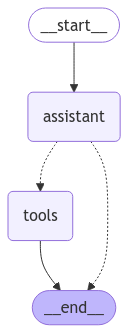

In [131]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import ToolNode, tools_condition

def assistant(state: MessagesState) -> MessagesState:
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder: StateGraph = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", END)

memory: MemorySaver = MemorySaver()

graph: CompiledStateGraph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

# Graph Invoke

In [132]:
initial_input = {"messages": HumanMessage(content="Hi")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! Welcome to our healthcare assistant chatbot. I'm here to assist you with general health questions, appointment bookings, and FAQs.  How can I help you today?


In [135]:
initial_input = {"messages": HumanMessage(content="Can you recommend me a doctor, I am having a cough for a week now?")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Can you recommend me a doctor, I am having a cough for a week now?
================================== Ai Message ==================================
Tool Calls:
  recommend_doctor (a6bd0e92-ce6b-44dc-9321-1dae2d049017)
 Call ID: a6bd0e92-ce6b-44dc-9321-1dae2d049017
  Args:
    symptoms: cough
================================= Tool Message =================================
Name: recommend_doctor

I recommend you see Dr. John Smith (General Physician) for 'cough'.


In [136]:
initial_input = {"messages": HumanMessage(content="Can you schedule my appointment with him?")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Can you schedule my appointment with him?
================================== Ai Message ==================================

I'd be happy to help you schedule an appointment with Dr. John Smith. To do so, I'll need your name and your preferred date and time for the appointment.  Please also tell me a bit more about your cough; for example, is it dry or productive (bringing up phlegm)?  This information will help Dr. Smith prepare for your visit.


In [137]:
initial_input = {"messages": HumanMessage(content="My name is Shazil Ali, 20 December, 8:00 pm, I am having cough")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

My name is Shazil Ali, 20 December, 8:00 pm, I am having cough
================================== Ai Message ==================================
Tool Calls:
  appointment_booking (b25fd24c-7efb-48ef-844f-5a3cb3c8b690)
 Call ID: b25fd24c-7efb-48ef-844f-5a3cb3c8b690
  Args:
    user_input: My name is Shazil Ali, 20 December, 8:00 pm, I am having cough
================================= Tool Message =================================
Name: appointment_booking

Appointment confirmed!
Patient Name: Shazil Ali
Date: 20 December
Time: 12:00 AM
Doctor: Dr. John Smith (General Physician) (specialist for 'cough')

If you need to reschedule or cancel, please let me know.


In [138]:
initial_input = {"messages": HumanMessage(content="Can you tell me the hospital timings?")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Can you tell me the hospital timings?
================================== Ai Message ==================================
Tool Calls:
  faqs (1eefc1d8-5957-49a8-9525-469af1bf14dd)
 Call ID: 1eefc1d8-5957-49a8-9525-469af1bf14dd
  Args:
    user_input: hospital timings
================================= Tool Message =================================
Name: faqs

We are open 24/7 for emergencies. Regular outpatient services are available from 8 AM to 8 PM.


In [139]:
initial_input = {"messages": HumanMessage(content="I have an emergency, how can i contact the hospital reception?")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

I have an emergency, how can i contact the hospital reception?
================================== Ai Message ==================================
Tool Calls:
  staff_query (e07cb2e4-cbf3-4c66-af70-1d3fcabb3892)
 Call ID: e07cb2e4-cbf3-4c66-af70-1d3fcabb3892
  Args:
    user_input: I have an emergency, how can i contact the hospital reception?
================================= Tool Message =================================
Name: staff_query

I'm sorry that I cannot assist with this directly. For emergencies, please contact our staff immediately at 123-456-7890. For other complex issues, you can email us at support@hospital.com. Let me know if there’s anything else I can help with.
